In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
import datetime

import math
import seaborn as sns
import scipy.stats as stats

from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import Point, MultiPoint

import geopandas as gpd


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
spray = pd.read_csv('../data/spray.csv')

i'm just going through a preliminary overview of the spray dataset..

In [3]:
spray.head()

,Date,Time,Latitude,Longitude
0,29/8/2011,6:56:58 PM,42.391623,-88.089163
1,29/8/2011,6:57:08 PM,42.391348,-88.089163
2,29/8/2011,6:57:18 PM,42.391022,-88.089157
3,29/8/2011,6:57:28 PM,42.390637,-88.089158
4,29/8/2011,6:57:38 PM,42.390410,-88.088858


In [4]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [5]:
# pandas_profiling.ProfileReport(spray)

In [6]:
# create another copy of spray to work on
spray1 = spray.copy()

### Handling null values and duplicates

Examine spray dataset for null values

In [7]:
spray1[spray1.isna().any(axis=1)].head()

,Date,Time,Latitude,Longitude
1030,7/9/2011,NaN,41.987092,-87.794286
1031,7/9/2011,NaN,41.987620,-87.794382
1032,7/9/2011,NaN,41.988004,-87.794574
1033,7/9/2011,NaN,41.988292,-87.795486
1034,7/9/2011,NaN,41.988100,-87.796014


Looks like `Time` is the main source of NaN cells? Let's check if other columns have NaN

In [8]:
spray1.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

We've confirmed that all the null rows were caused by missing data for `Time`. Time data is probably too finely tuned for our needs, so we might drop `Time` from spray instead. 

But first, we want to explore our duplicate spray rows.

In [9]:
# looking at our dupes
spray1[spray1.duplicated(keep=False)].head(20)

,Date,Time,Latitude,Longitude
484,7/9/2011,7:43:40 PM,41.983917,-87.793088
485,7/9/2011,7:43:40 PM,41.983917,-87.793088
489,7/9/2011,7:44:32 PM,41.986460,-87.794225
490,7/9/2011,7:44:32 PM,41.986460,-87.794225
491,7/9/2011,7:44:32 PM,41.986460,-87.794225
492,7/9/2011,7:44:32 PM,41.986460,-87.794225
493,7/9/2011,7:44:32 PM,41.986460,-87.794225
494,7/9/2011,7:44:32 PM,41.986460,-87.794225
495,7/9/2011,7:44:32 PM,41.986460,-87.794225
496,7/9/2011,7:44:32 PM,41.986460,-87.794225


In [10]:
# examing one of the records that have a lot of duplicates
spray1.loc[(spray1["Date"] == "2011-09-07") & (spray1["Latitude"]==41.986460) & (spray1["Longitude"]==-87.794225)]

,Date,Time,Latitude,Longitude


Plotting spray points on the map

In [11]:
spray1.head()

,Date,Time,Latitude,Longitude
0,29/8/2011,6:56:58 PM,42.391623,-88.089163
1,29/8/2011,6:57:08 PM,42.391348,-88.089163
2,29/8/2011,6:57:18 PM,42.391022,-88.089157
3,29/8/2011,6:57:28 PM,42.390637,-88.089158
4,29/8/2011,6:57:38 PM,42.390410,-88.088858


In [12]:
spray1.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

In [13]:
spray1['Date'] = pd.to_datetime(spray1.Date)

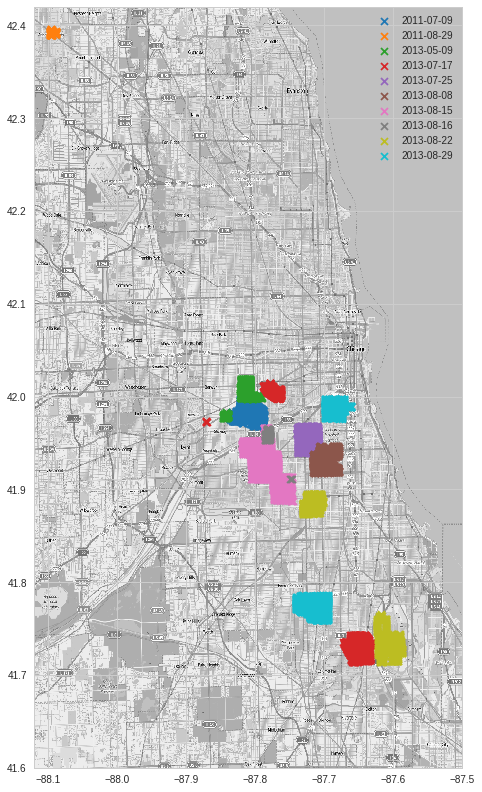

In [14]:
spray_df = spray1
unique_dates = sorted(spray_df['Date'].unique())
mapdata = np.loadtxt("../data/resources/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88.12, -87.5, 41.6, 42.42)
plt.figure(figsize=(10,14))
plt.imshow(mapdata,
           cmap=plt.get_cmap('gray'),
           extent=lon_lat_box,
           aspect=aspect)
for i in range(len(unique_dates)):
    traps = spray_df.loc[spray_df['Date'] == unique_dates[i]]
    locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], marker='x', label=unique_dates[i].astype(str)[:10])
    plt.legend()

Now, to remove anomany points: 
- Drop spray data with latitude > 42.1
- As for the pink and grey spray area, spray process had started on the 15th August 2013 8pm and ended after 12mn. As such the spray data recorded after 12mn have been classified as 16th August 2013. As such, they have to be changed to the same date, 15 Aug 2013
- 5 points with a recorded AM time remain as aomaly points (red cross). They will be removed


In [15]:
spray1 = spray1[spray1['Latitude'] < 42.1]

In [16]:
spray1.head()

,Date,Time,Latitude,Longitude
95,2011-07-09,7:52:52 PM,41.981433,-87.787777
96,2011-07-09,7:53:02 PM,41.980998,-87.787778
97,2011-07-09,7:53:12 PM,41.980560,-87.787762
98,2011-07-09,7:53:22 PM,41.980198,-87.787758
99,2011-07-09,7:53:32 PM,41.979752,-87.787765


In [17]:
spray1.dtypes

Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
dtype: object

In [18]:
# The code for merging the dates 2013-08-15 and 2013-08-16
mask = (spray_df['Time'].dropna().str.contains('AM')) & \
      ~(spray_df['Time'].dropna().str[:2] == '10')
spray1.loc[spray1['Time'].dropna().loc[mask].index, 'Date'] = datetime.datetime(2013, 8, 15)

/home/dev/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
spray1.loc[spray1['Time'].dropna().loc[mask].index, 'Date']

9881    2013-08-15
9882    2013-08-15
9883    2013-08-15
9884    2013-08-15
9885    2013-08-15
9886    2013-08-15
9887    2013-08-15
9888    2013-08-15
9889    2013-08-15
9890    2013-08-15
9891    2013-08-15
9892    2013-08-15
9893    2013-08-15
9894    2013-08-15
9895    2013-08-15
9896    2013-08-15
9897    2013-08-15
9898    2013-08-15
9899    2013-08-15
9900    2013-08-15
9901    2013-08-15
9902    2013-08-15
9903    2013-08-15
9904    2013-08-15
9905    2013-08-15
9906    2013-08-15
9907    2013-08-15
9908    2013-08-15
9909    2013-08-15
9910    2013-08-15
9911    2013-08-15
9912    2013-08-15
9913    2013-08-15
9914    2013-08-15
9915    2013-08-15
9916    2013-08-15
9917    2013-08-15
9918    2013-08-15
9919    2013-08-15
9920    2013-08-15
9921    2013-08-15
9922    2013-08-15
9923    2013-08-15
9924    2013-08-15
9925    2013-08-15
9926    2013-08-15
9927    2013-08-15
9928    2013-08-15
9929    2013-08-15
9930    2013-08-15
9931    2013-08-15
9932    2013-08-15
9933    2013

In [20]:
# Code for dropping records with 10 AM in Time feature
mask = (spray1['Time'].dropna().str.contains('AM')) & \
       (spray1['Time'].dropna().str[:2] == '10')
spray1.drop(spray1['Time'].dropna().loc[mask].index, inplace=True)

/home/dev/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
spray1.Date.unique()

array(['2011-07-09T00:00:00.000000000', '2013-07-17T00:00:00.000000000',
       '2013-07-25T00:00:00.000000000', '2013-08-08T00:00:00.000000000',
       '2013-08-15T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-05-09T00:00:00.000000000'],
      dtype='datetime64[ns]')

It's not clear why there are duplicate rows in the spray dataset. It might mean that there are multiple times a particular location was sprayed in a certain day. It could probably be a data collection error so we could drop those rows.

* drop `Time`

In [22]:
spray1 = spray1.drop(columns=["Time"])
spray1.head()

,Date,Latitude,Longitude
95,2011-07-09,41.981433,-87.787777
96,2011-07-09,41.980998,-87.787778
97,2011-07-09,41.980560,-87.787762
98,2011-07-09,41.980198,-87.787758
99,2011-07-09,41.979752,-87.787765


In [23]:
print(f"Spray shape before drop: {spray1.shape}")
spray1 = spray1.drop_duplicates(keep='first')
print(f"New spray shape: {spray1.shape}")

Spray shape before drop: (14735, 3)
New spray shape: (14194, 3)


Now, to find out 
* number of unique spray dates 
* number of sprays made on each unique date

In [24]:
print(spray1["Date"].nunique())
spray1["Date"].value_counts()

8


2013-08-15    2809
2013-08-29    2302
2013-07-17    2197
2013-07-25    1607
2013-08-22    1587
2011-07-09    1573
2013-08-08    1195
2013-05-09     924
Name: Date, dtype: int64

In [25]:
# spray.set_index('Date', inplace=True)

In [26]:
spray1.head()

,Date,Latitude,Longitude
95,2011-07-09,41.981433,-87.787777
96,2011-07-09,41.980998,-87.787778
97,2011-07-09,41.980560,-87.787762
98,2011-07-09,41.980198,-87.787758
99,2011-07-09,41.979752,-87.787765


In [27]:
spray1.dtypes

Date         datetime64[ns]
Latitude            float64
Longitude           float64
dtype: object

In [28]:
# Earliest collection
print(spray1['Date'].min())
# Latest collection
print(spray1['Date'].max())

2011-07-09 00:00:00
2013-08-29 00:00:00


In [29]:
spray1.dtypes.value_counts()

float64           2
datetime64[ns]    1
dtype: int64

In [30]:
# New columns for Year, Month, Day in DataFrame 
spray1['Year'] = spray1['Date'].dt.year
spray1['Month'] = spray1['Date'].dt.month
spray1['Day'] = spray1['Date'].dt.day
spray1['Week'] = spray1['Date'].dt.week

In [31]:
## make datetime columns
# spray['Year'] = spray['Date'].apply(lambda x:x.year)
# spray['Month'] = spray['Date'].apply(lambda x:x.month)
# spray['WeekofYear'] = spray['Date'].apply(lambda x:x.weekofyear)
# spray['YearMonth'] = spray['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

# # year 2007 - 2013
# print(spray.Year.value_counts().sort_index())

# # data only from may - oct
# print(spray.Month.value_counts())

# # week 22 - 41
# print(spray.WeekofYear.value_counts().sort_index())

# # total number of weeks in dataset
# print(spray.WeekofYear.nunique())

In [32]:
spray1.head()

,Date,Latitude,Longitude,Year,Month,Day,Week
95,2011-07-09,41.981433,-87.787777,2011,7,9,27
96,2011-07-09,41.980998,-87.787778,2011,7,9,27
97,2011-07-09,41.980560,-87.787762,2011,7,9,27
98,2011-07-09,41.980198,-87.787758,2011,7,9,27
99,2011-07-09,41.979752,-87.787765,2011,7,9,27


In [33]:
spray1.isnull().sum()
# spray['Time'].isnull().sum()

Date         0
Latitude     0
Longitude    0
Year         0
Month        0
Day          0
Week         0
dtype: int64

In [34]:
round(spray1['Longitude'],1).value_counts()

-87.7    6814
-87.8    5798
-87.6    1582
Name: Longitude, dtype: int64

In [35]:
round(spray1['Latitude'],1).value_counts()

42.0    5434
41.9    5001
41.7    2318
41.8    1441
Name: Latitude, dtype: int64

In [36]:
np.unique(spray1['Date'])

array(['2011-07-09T00:00:00.000000000', '2013-05-09T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-22T00:00:00.000000000', '2013-08-29T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [37]:
spray1[['Latitude','Longitude']].describe()

,Latitude,Longitude
count,14194.000000,14194.000000
mean,41.898430,-87.732062
std,0.097469,0.061051
min,41.713925,-87.846338
25%,41.782254,-87.788558
50%,41.937193,-87.724379
75%,41.976738,-87.691569
max,42.018907,-87.586727


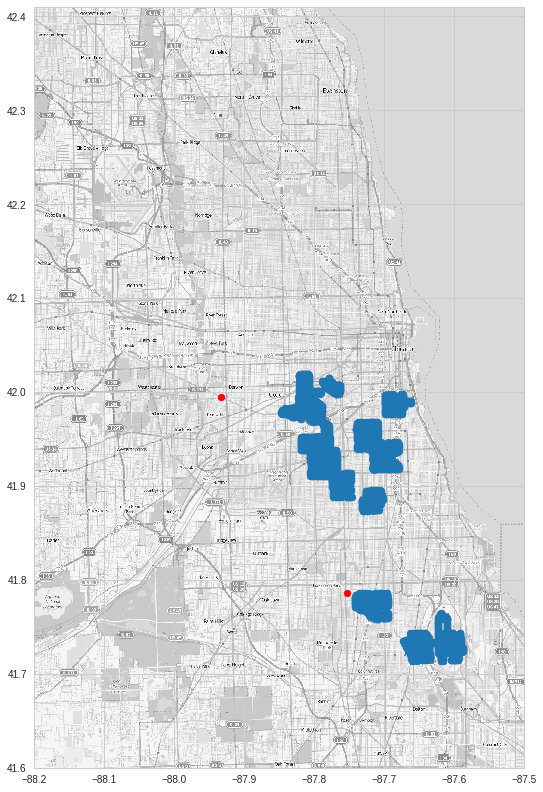

In [38]:
mapdata = np.loadtxt("../data/resources/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88.2, -87.5, 41.6, 42.41)

plt.figure(figsize=(12,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('Greys_r'), 
           extent=lon_lat_box, 
           aspect=aspect)

# locations = aggregated[['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter([-87.933,-87.752],[41.995,41.786], marker = 'o', c='red')
plt.scatter(spray1.Longitude, spray1.Latitude ,marker = 'o')

In [39]:
# Export as CSV
spray1.to_csv('../data/spray_cleaned.csv')

### Tracking nearest spray location for each trap record

Using each trap record's date and location, we want to find out if there was any spray activity in recent dates (e.g. within 3 days, within 7 days), then find out the nearest spray location.

In [40]:
# creating a set of unique spray dates
unique_spray_dates = set (spray1["Date"].unique())
unique_spray_dates

{numpy.datetime64('2011-07-09T00:00:00.000000000'),
 numpy.datetime64('2013-05-09T00:00:00.000000000'),
 numpy.datetime64('2013-07-17T00:00:00.000000000'),
 numpy.datetime64('2013-07-25T00:00:00.000000000'),
 numpy.datetime64('2013-08-08T00:00:00.000000000'),
 numpy.datetime64('2013-08-15T00:00:00.000000000'),
 numpy.datetime64('2013-08-22T00:00:00.000000000'),
 numpy.datetime64('2013-08-29T00:00:00.000000000')}

In [41]:
train_data = pd.read_csv('../data/train_cleaned.csv')

In [42]:
# this function takes in a dataframe and returns a GeoPanda dataframe
# longitude and latitude columns will be formatted into geographic columns
# date columns will be formatted into datetime columns

def gpd_date(df): 
    
    # passing df into a GeoPanda
    
    # creating geometric point
    geom = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
    # creating a GeoPanda dataframe
    g_df = df.copy()
    g_df = gpd.GeoDataFrame(df, geometry=geom)

    # adding coordinates
    g_df["Coord"] = list(zip(g_df.Latitude, g_df.Longitude))
    
    # formatting `Date` column into a datetime column
    g_df["Date"] = pd.to_datetime(g_df["Date"],format='%Y-%m-%d')
    g_df['Date'] = g_df['Date'].dt.date
    
    # creating a `YearMonth` column for ease of comparison
    g_df['YearMonth'] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    
    # creating a month column
    g_df["Year"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.year)).astype(int)
    
    # creating a month column
    g_df["Month"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.month)).astype(int)
    
    # creating a day column
    g_df["Day"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.day)).astype(int)
    
    # creating a week column
    g_df["Week"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.week)).astype(int)
    

    return g_df

In [43]:
g_train = gpd_date(train_data)
g_train.head()

,Date,Species,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Month,Year,Station,geometry,Coord,YearMonth,Day,Week
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,1,POINT (-87.80099 41.95469),"(41.95469, -87.800991)",2007-05,29,22
1,2007-05-29,CULEX RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,1,POINT (-87.80099 41.95469),"(41.95469, -87.800991)",2007-05,29,22
2,2007-05-29,CULEX RESTUANS,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,5,2007,1,POINT (-87.76928 41.99499),"(41.994991, -87.769279)",2007-05,29,22
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,5,2007,1,POINT (-87.82481 41.97409),"(41.974089, -87.824812)",2007-05,29,22
4,2007-05-29,CULEX RESTUANS,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,5,2007,1,POINT (-87.82481 41.97409),"(41.974089, -87.824812)",2007-05,29,22


In [44]:
# this function locates the nearest spray site based on recent spray activity
# it takes in `ndays`, then # looks up the spray dataframe to generate an `intersect` set of spray dates  within ndays of the trap record
# as long as a spray date is within ndays of the trap record, the main table will be updated with 
# the location of the nearest spray site and calculates the distance between the trap and that nearest spray site

def nearest_spray(ndays):
    
        ndays_intersect_dates = "n" + str(ndays) + "_" + "intersect_dates"
        ndays_spray_sets = "n" + str(ndays) + "_" + "spray_sets"
        ndays_spray_geom = "n" + str(ndays) + "_" + "spray_geom"
        ndays_spray_coord = "n" + str(ndays) + "_" + "spray_coord"
        ndays_spray_dist_deg = "n" + str(ndays) + "_" + "spray_dist_deg"
        ndays_spray_dist_m = "n" + str(ndays) + "_" + "spray_dist_m"
        
        # this column will store the range of spray dates that were within ndays of a trap record's date 
        g_train[ndays_intersect_dates] = None
        
        # this column will store the gemoetric points of spray sites that were within ndays of a trap record's date 
        g_train[ndays_spray_sets] = None
        
        # this column will store the geometric point of the nearest spray site
        g_train[ndays_spray_geom] = None
        
        # this column will store the coordinates of the nearest spray site
        g_train[ndays_spray_coord] = None
        
        # this column will store the geometric distance between the trap location and the nearest spray site
        g_train[ndays_spray_dist_deg] = None
        
        # this column will store the distance (in metres) between the trap location and the nearest spray site
        g_train[ndays_spray_dist_m] = None
        
        
        n_days = ndays
        
        count = 0

        # populating `ndays_intersect_dates` and `ndays_spray_geom`
        for index, row in g_train.iterrows():

            # date_range contains a range of dates that were within n_days of a trap record's date, including the trap record date
            date_range = set (row["Date"] - dt.timedelta(days=x) for x in range(n_days))
#             print("in date range")
#             print(date_range)

            # intersect contains spray dates that coincide with each trap record's date_range
            intersect = unique_spray_dates.intersection(date_range)
#             print(intersect)
#             print()

            # when interect is not empty
            if len(intersect)!=0:
                
                # passing the set of intersecting dates to `ndays_intersect_dates`
                g_train[ndays_intersect_dates][index]= intersect

                # creating a subset of the spray dataframe using only dates in intersect
                spray_subset = g_spray[g_spray["Date"].isin(intersect)]
                # creating a MultiPoint object using spray_subset
                spray_unary = spray_subset.geometry.unary_union               
                # storing spray_unary 
                g_train[ndays_spray_sets][index] = spray_unary
                
                # finding the point in spray_unary that's nearest to our current trap_point
                trap_point = row.geometry
                queried_geom, nearest_geom = nearest_points(trap_point, spray_unary)
                g_train[ndays_spray_geom][index] = nearest_geom
                
                # storing coordinate of the nearest spray point
                # points are in lon, lat so we need to reverse them
                spray_coord = nearest_geom.y, nearest_geom.x
                g_train[ndays_spray_coord][index] = spray_coord

                # calculating geometric distance between trap point and spray point
                g_train[ndays_spray_dist_deg][index] = g_train[ndays_spray_geom][index].distance(g_train['geometry'][index])
                
                # caclulating distance (in metres) between trap point and spray point
                g_train[ndays_spray_dist_m][index] = geodesic(g_train["Coord"][index], spray_coord).m
                

                count = count+1

            else:
                pass
        
        
        # casting `ndays_spray_dist_deg` into a numeric type so that we can compare correlation with `NumMosquitos` and `WnvPresent`
        g_train[ndays_spray_dist_deg] = g_train[ndays_spray_dist_deg].astype(float)

        
        # casting `ndays_spray_dist_m` into a numeric type so that we can compare correlation with `NumMosquitos` and `WnvPresent`
        g_train[ndays_spray_dist_m] = g_train[ndays_spray_dist_m].astype(float)

        print("Number of rows updated:", count)
        print(f"{ndays_spray_dist_deg} successfully cast to: {g_train[ndays_spray_dist_deg].dtype}")
        print(f"{ndays_spray_dist_m} successfully cast to: {g_train[ndays_spray_dist_m].dtype}")

### Total mosquito count by Year-Month (species combined)

Based on the "Date" column, we will create new columns indicating the "year", "month" and the "weekofyear" columns to streamline our EDA. It is important as the data represented only a certain time period within each year;

- year -> 2007 - 2014
- month -> may - oct (corresponding to when traps are deployed)
- weekofyear -> 17 - 44

Since there are 2 weather stations capturing the weather statistics each day, we will explore the differences in the data captured for each station, mainly focusing on the columns "Tavg" and "PrecipTotal" which are likely to provide more information on our target.

Generally, the temperature cycle climbs from May to August and peak in July (with the exception of 2007 and 2014 where the peak is in August) before starting to decrease from August.